In [1]:
#hopper.ipynb
#
#by Joe Hahn
#jmh.datasciences@gmail.com
#5 February 2018
#
#hopper uses Q-learning to teach a neural net AI to...

In [2]:
#game settings
max_moves = 1000
max_distance = 15.0
rn_seed = 123

In [3]:
#import the hopper game
from hopper import *
import time
time_start = time.time()

In [4]:
#import plotting libraries
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5, font='DejaVu Sans')

In [5]:
#initialize system
N_moves = 1
environment = initialize_environment(rn_seed, max_moves, max_distance)
state = initialize_state(environment)
reward = get_reward(state, environment)
separation, angle = get_separation(state)
game_state = get_game_state(N_moves, state, environment)
print 'environment = ', environment
print 'acts = ', environment['acts']
print 'actions = ', environment['actions']
print 'state = ', state
print 'reward = ', reward
print 'separation = ', separation
print 'angle = ', angle
print 'game_state = ', game_state

environment =  {'max_moves': 1000, 'max_distance': 15.0, 'rn_seed': 123, 'acts': ['slow-left', 'slow-right', 'fast-left', 'fast-right', 'turnaround'], 'actions': [0, 1, 2, 3, 4]}
acts =  ['slow-left', 'slow-right', 'fast-left', 'fast-right', 'turnaround']
actions =  [0, 1, 2, 3, 4]
state =  {'cat_run_direction_angle': -0.48068902261812602, 'bug_direction_angle': -0.48068902261812602, 'bug_distance': 0.40225757966792652, 'bug': array([ 0.,  0.]), 'cat': array([-0.35667236,  0.18599997])}
reward =  2.14556001769
separation =  0.402257579668
angle =  -0.480689022618
game_state =  running


In [6]:
#play one game, with slow cat
strategy = 'slow'
memories = play_game(environment, strategy)
cat, bug, actions, rewards, bug_distances, bug_direction_angles, cat_direction_angles, turns = \
    memories2arrays(memories)
cumulative_rewards = rewards.cumsum()
mean_cat_bug_separations = bug_distances.mean()
memories_slow = memories
print 'strategy = ', strategy
print 'max cumulative_rewards = ', cumulative_rewards.max()
print 'mean_cat_bug_separations = ', mean_cat_bug_separations

strategy =  slow
max cumulative_rewards =  491.404934015
mean_cat_bug_separations =  1.82208781916


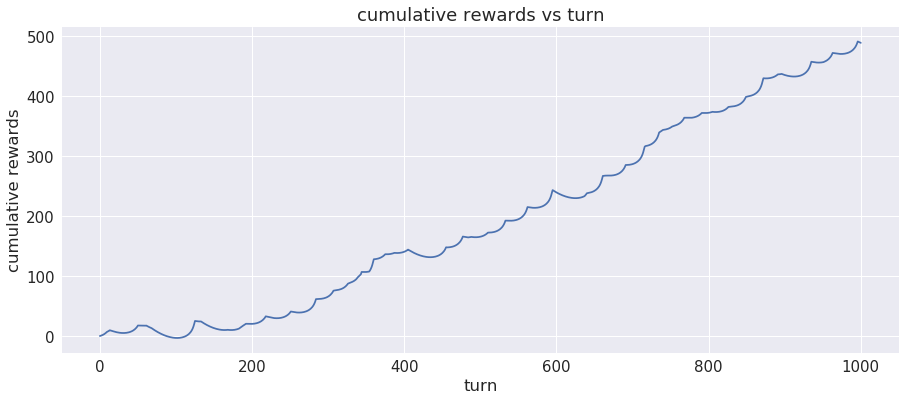

In [7]:
#plot cumulative vs turn
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = turns
yp = cumulative_rewards
ax.plot(xp, yp)
ax.set_title('cumulative rewards vs turn')
ax.set_xlabel('turn')
ax.set_ylabel('cumulative rewards')
plt.savefig('figs/rewards.png')

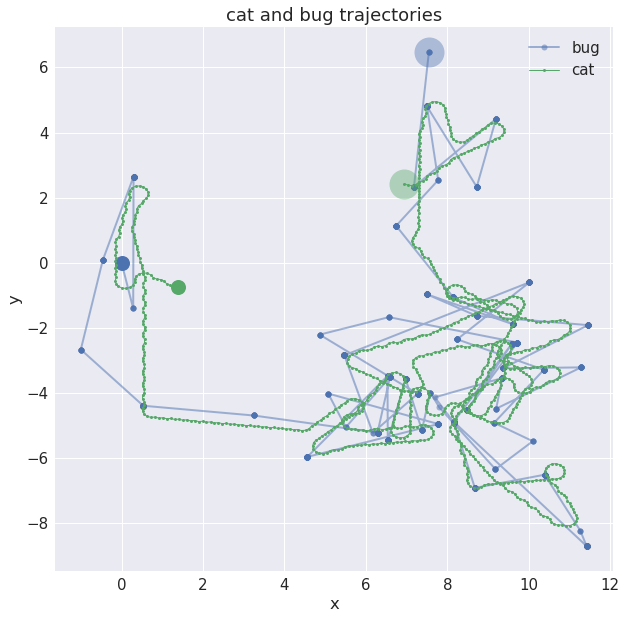

In [8]:
#plot cat and bug trajectories
fig, ax = plt.subplots(1,1, figsize=(10, 10))
xp = bug[:,0]
yp1 = bug[:,1]
colors=sns.color_palette()
ax.plot(xp, yp1, marker='o', markersize=6, linewidth=2, alpha=0.5, color=colors[0], label='bug')
ax.plot(xp[0], yp1[0], marker='o', markersize=15, color=colors[0])
ax.plot(xp[-1], yp1[-1], marker='o', markersize=30, color=colors[0], alpha=0.4)
xp = cat[:,0]
yp2 = cat[:,1]
ax.plot(xp, yp2, marker='o', markersize=3, linestyle='-', linewidth=1, color=colors[1], label='cat')
ax.plot(xp[0], yp2[0], marker='o', markersize=15, color=colors[1])
ax.plot(xp[-1], yp2[-1], marker='o', markersize=30, color=colors[1], alpha=0.4)
ax.set_title('cat and bug trajectories')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend()
plt.savefig('figs/xy.png')

In [9]:
#play one game, with fast cat
strategy = 'fast'
memories = play_game(environment, strategy)
cat, bug, actions, rewards, bug_distances, bug_direction_angles, cat_direction_angles, turns = \
    memories2arrays(memories)
cumulative_rewards = rewards.cumsum()
mean_cat_bug_separations = bug_distances.mean()
memories_fast = memories
print 'strategy = ', strategy
print 'max cumulative_rewards = ', cumulative_rewards.max()
print 'mean_cat_bug_separations = ', mean_cat_bug_separations

strategy =  fast
max cumulative_rewards =  523.321161483
mean_cat_bug_separations =  1.80641607023


Text(0,0.5,u'cumulative rewards')

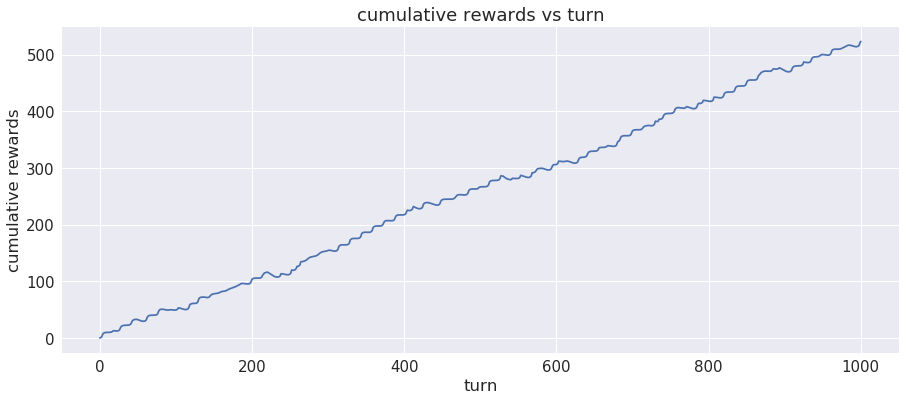

In [10]:
#plot cumulative rewards vs turn
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = turns
yp = cumulative_rewards
ax.plot(xp, yp)
ax.set_title('cumulative rewards vs turn')
ax.set_xlabel('turn')
ax.set_ylabel('cumulative rewards')

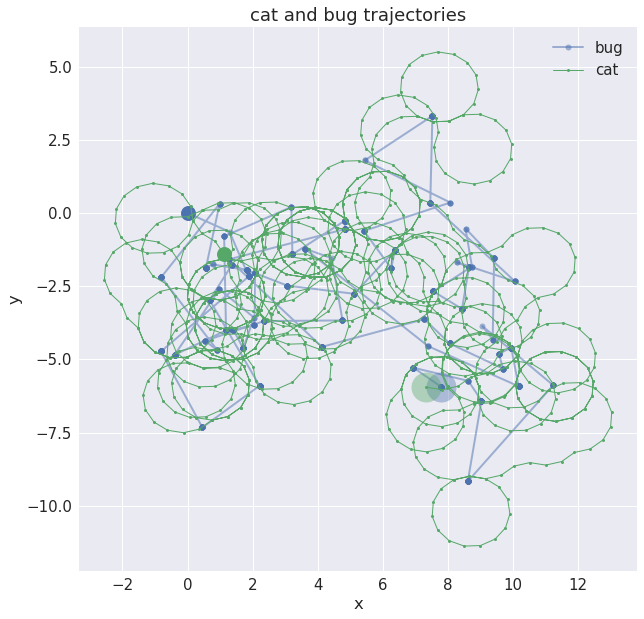

In [11]:
#plot cat and bug trajectories
fig, ax = plt.subplots(1,1, figsize=(10, 10))
xp = bug[:,0]
yp1 = bug[:,1]
colors=sns.color_palette()
ax.plot(xp, yp1, marker='o', markersize=6, linewidth=2, alpha=0.5, color=colors[0], label='bug')
ax.plot(xp[0], yp1[0], marker='o', markersize=15, color=colors[0])
ax.plot(xp[-1], yp1[-1], marker='o', markersize=30, color=colors[0], alpha=0.4)
xp = cat[:,0]
yp2 = cat[:,1]
ax.plot(xp, yp2, marker='o', markersize=3, linestyle='-', linewidth=1, color=colors[1], label='cat')
ax.plot(xp[0], yp2[0], marker='o', markersize=15, color=colors[1])
ax.plot(xp[-1], yp2[-1], marker='o', markersize=30, color=colors[1], alpha=0.4)
ax.set_title('cat and bug trajectories')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend()

In [12]:
#generate memories of 100 slow & fast games (same number of games as used during training)
#these will be used by trainer's experience-replay algorithm
N_games = 50
strategies = ['slow', 'fast']
memories_list = []
N_memories = 0
for strategy in strategies:
    for N_game in range(N_games):
        memories = play_game(environment, strategy)
        memories_list += [memories]
        N_memories += len(memories)
memories = deque(maxlen=N_memories)
for buncha_memories in memories_list:
    for m in buncha_memories:
        memories.append(m)
print 'number of memories = ', len(memories)

number of memories =  100100


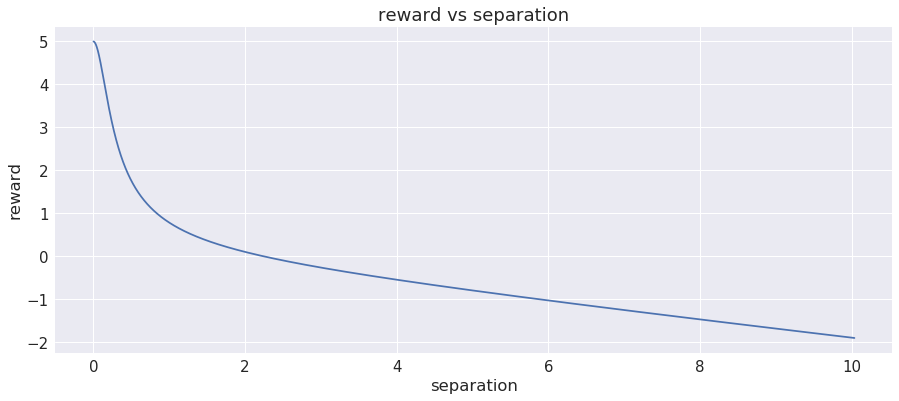

In [13]:
#plot reward vs separation
states = [m[0] for m in memories]
bug_distances = np.array([state['bug_distance'] for state in states])
rewards = np.array([get_reward(state, environment) for state in states])
idx = bug_distances.argsort()
bug_distances = bug_distances[idx]
rewards = rewards[idx]
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = bug_distances
yp = rewards
ax.plot(xp, yp)
ax.set_title('reward vs separation')
ax.set_xlabel('separation')
ax.set_ylabel('reward')
plt.savefig('figs/reward_vs_separation.png')

In [14]:
#build neural network model
state_vector = state2vector(state)
N_inputs = state_vector.shape[1]
N_outputs = len(environment['actions'])
N_neurons = 24
model = build_model(N_inputs, N_neurons, N_outputs)
print model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                96        
_________________________________________________________________
activation_1 (Activation)    (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
activation_2 (Activation)    (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 125       
_________________________________________________________________
activation_3 (Activation)    (None, 5)                 0         
Total params: 821
Trainable params: 821
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
#Use Q-learning to train neural network to drive cat torwards bug..about 4 minutes to execute.
N_training_games = 100
gamma = 0.85                              #discount for future rewards
batch_size = 100                          #number of memories used during experience-replay
print 'batch_size = ', batch_size
debug = False
print 'training model...'
trained_model = train(environment, model, N_training_games, max_distance, gamma, memories, batch_size, debug=debug)
print 'training done.'

batch_size =  100
training model...
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

training done.


In [16]:
#play one game using trained ai to guide cat
strategy = 'smart'
memories = play_game(environment, strategy, model=trained_model)
cat, bug, actions, rewards, bug_distances, bug_direction_angles, cat_direction_angles, turns = \
    memories2arrays(memories)
cumulative_rewards = rewards.cumsum()
mean_cat_bug_separations = bug_distances.mean()
memories_smart = memories
print 'strategy = ', strategy
print 'final cumulative_rewards = ', cumulative_rewards[-1]
print 'mean_cat_bug_separations = ', mean_cat_bug_separations

strategy =  smart
final cumulative_rewards =  981.321198774
mean_cat_bug_separations =  2.08762501613


Text(0,0.5,u'cumulative rewards')

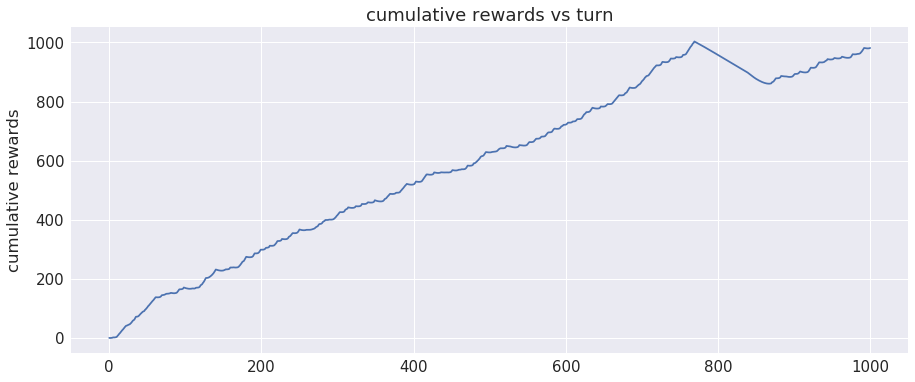

In [17]:
#plot cumulative rewards vs turn
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = turns
yp = cumulative_rewards
ax.plot(xp, yp)
ax.set_title('cumulative rewards vs turn')
ax.set_ylabel('cumulative rewards')

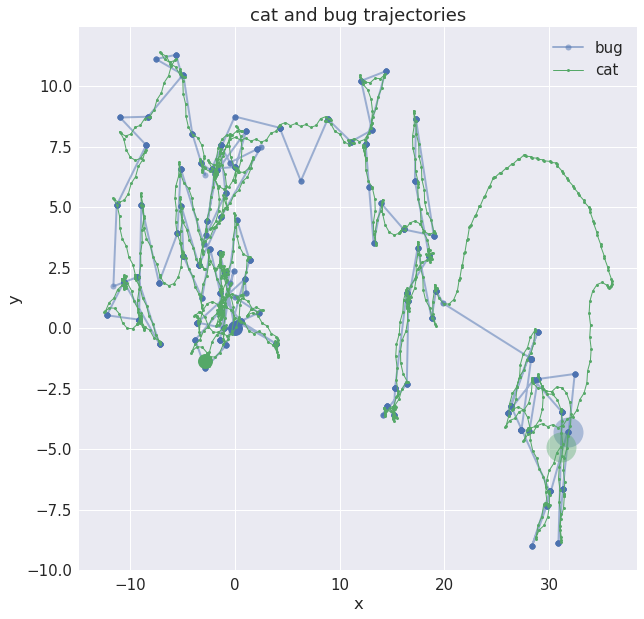

In [18]:
#plot cat and bug trajectories
fig, ax = plt.subplots(1,1, figsize=(10, 10))
xp = bug[:,0]
yp1 = bug[:,1]
colors=sns.color_palette()
ax.plot(xp, yp1, marker='o', markersize=6, linewidth=2, alpha=0.5, color=colors[0], label='bug')
ax.plot(xp[0], yp1[0], marker='o', markersize=15, color=colors[0])
ax.plot(xp[-1], yp1[-1], marker='o', markersize=30, color=colors[0], alpha=0.4)
xp = cat[:,0]
yp2 = cat[:,1]
ax.plot(xp, yp2, marker='o', markersize=3, linestyle='-', linewidth=1, color=colors[1], label='cat')
ax.plot(xp[0], yp2[0], marker='o', markersize=15, color=colors[1])
ax.plot(xp[-1], yp2[-1], marker='o', markersize=30, color=colors[1], alpha=0.4)
ax.set_title('cat and bug trajectories')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend()
plt.savefig('figs/xy_smart.png')

In [19]:
#number of times cat utilized various actions
for action in environment['actions']:
    print action, environment['acts'][action], (actions == action).sum()

0 slow-left 5
1 slow-right 128
2 fast-left 384
3 fast-right 313
4 turnaround 171


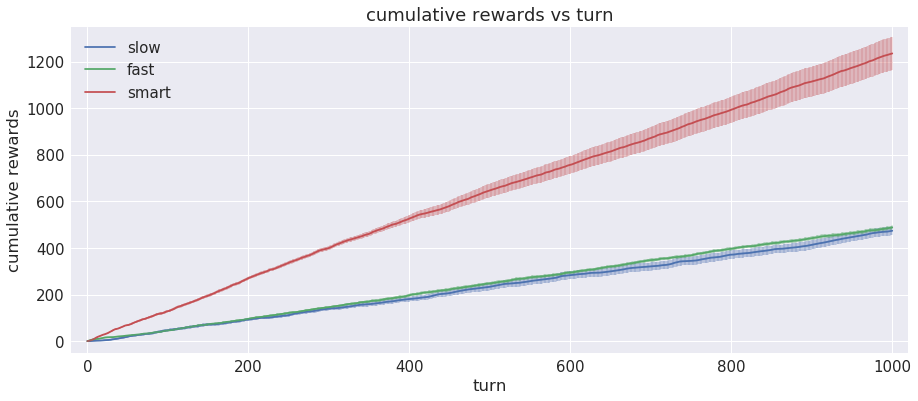

In [20]:
#for each strategy play 20 games
N_games = 20
rn_seed = 132
strategies = ['slow', 'fast', 'smart']
median_cat_bug_separations = []
for strategy in strategies:
    cumulative_rewards_list = []
    median_cat_bug_separations_list = []
    for N_game in range(N_games):
        rn_seed += 1
        environment = initialize_environment(rn_seed, max_moves, max_distance)
        memories = play_game(environment, strategy, model=trained_model)
        cat, bug, actions, rewards, bug_distances, bug_direction_angles, cat_direction_angles, turns = \
            memories2arrays(memories)
        cumulative_rewards_list += [rewards.cumsum()]
        median_cat_bug_separations_list += [np.median(bug_distances)]
    cumulative_rewards_mean = np.array(cumulative_rewards_list).mean(axis=0)
    cumulative_rewards_std = np.array(cumulative_rewards_list).std(axis=0)/np.sqrt(N_games-1)
    median_cat_bug_separations += [np.array(median_cat_bug_separations_list).mean()]
    if (strategy == strategies[0]):
        fig, ax = plt.subplots(1,1, figsize=(15, 6))
        ax.set_title('cumulative rewards vs turn')
        ax.set_xlabel('turn')
        ax.set_ylabel('cumulative rewards')
        ax.set_xlim(-20, 1020)
        ax.set_ylim(-50, 1350)
    xp = turns
    yp = cumulative_rewards_mean
    err = cumulative_rewards_std
    p = ax.plot(xp, yp, label=strategy)
    ax.errorbar(xp, yp, yerr=err, alpha=0.2, color=p[0].get_color())
ax.legend()
plt.savefig('figs/strategy_rewards.png')

[1.7608379837218393, 1.8286594725809131, 1.1332275642879233]


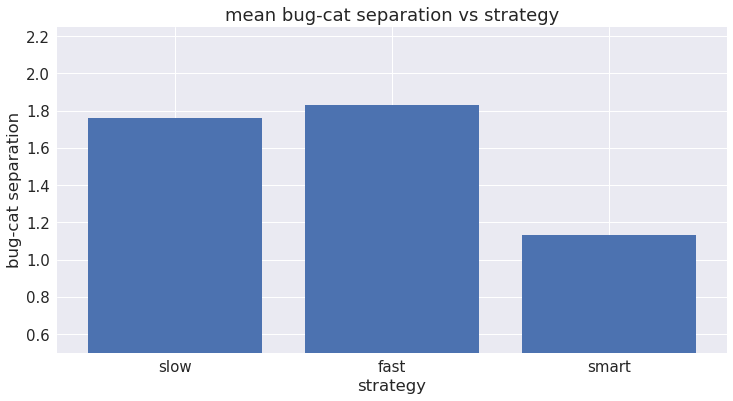

In [21]:
#plot mean bug-cat separation vs strategy
fig, ax = plt.subplots(1,1, figsize=(12, 6))
xp = range(len(strategies))
yp = median_cat_bug_separations
p = ax.bar(xp, yp, width=0.8, align='center')
p = ax.set_xticks(xp)  
p = ax.set_xticklabels(strategies)
p = ax.set_title('mean bug-cat separation vs strategy')
p = ax.set_xlabel('strategy')
p = ax.set_ylabel('bug-cat separation')
p = ax.set_ylim(0.5, 2.25)
plt.savefig('figs/separation_strategy.png')
print yp

In [22]:
#done!
time_stop = time.time()
print 'execution time (minutes) = ', (time_stop - time_start)/60.0

execution time (minutes) =  3.77872216702
